# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demo(graphics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')
azdias1 = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.head())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                     

In [4]:
print(feat_info.head())

              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]


In [5]:
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
azdias.isnull().sum().sum()

4896838

In [8]:
feat_info["missing_or_unknown"]

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [9]:
[feat_info["missing_or_unknown"][1:-1]]

[1     [-1,0,9]
 2       [-1,0]
 3          [0]
 4         [-1]
 5         [-1]
 6         [-1]
 7         [-1]
 8         [-1]
 9         [-1]
 10        [-1]
 11         [0]
 12          []
 13          []
 14      [-1,0]
 15         [0]
 16         [0]
 17         [0]
 18         [0]
 19         [0]
 20         [0]
 21      [-1,0]
 22      [-1,0]
 23         [0]
 24      [-1,9]
 25      [-1,9]
 26      [-1,9]
 27      [-1,9]
 28      [-1,9]
 29      [-1,9]
 30      [-1,9]
         ...   
 54         [0]
 55        [-1]
 56        [-1]
 57      [-1,X]
 58        [XX]
 59     [-1,XX]
 60        [-1]
 61        [-1]
 62        [-1]
 63        [-1]
 64      [-1,0]
 65      [-1,0]
 66        [-1]
 67        [-1]
 68        [-1]
 69          []
 70      [-1,0]
 71          []
 72          []
 73      [-1,0]
 74          []
 75        [-1]
 76        [-1]
 77        [-1]
 78        [-1]
 79      [-1,0]
 80        [-1]
 81        [-1]
 82      [-1,9]
 83      [-1,0]
 Name: missing_or_unknow

In [10]:
def to_list_missing(missing_or_unknown):
    new_list = list()
    for values in missing_or_unknown:
        new_list.append(values[1:-1].split(","))
    return new_list

missing_values=to_list_missing(feat_info["missing_or_unknown"])
missing_values

[['-1', '0'],
 ['-1', '0', '9'],
 ['-1', '0'],
 ['0'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['0'],
 [''],
 [''],
 ['-1', '0'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['-1', '0'],
 ['-1', '0'],
 ['0'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1'],
 ['-1'],
 ['-1', '0'],
 ['-1'],
 ['-1', '9'],
 ['0'],
 [''],
 [''],
 ['-1', '0'],
 ['-1'],
 ['-1', '0'],
 ['-1', '0'],
 ['0'],
 [''],
 ['-1', '0'],
 [''],
 ['0'],
 ['-1'],
 ['-1'],
 ['-1', 'X'],
 ['XX'],
 ['-1', 'XX'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1', '0'],
 ['-1', '0'],
 ['-1'],
 ['-1'],
 ['-1'],
 [''],
 ['-1', '0'],
 [''],
 [''],
 ['-1', '0'],
 [''],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1', '0'],
 ['-1'],
 ['-1'],
 ['-1', '9'],
 ['-1', '0'],
 ['-1', '9']]

In [11]:
def replace_nulls(df1,mv,info):
    for i in range(len(mv)):
        for j in range(len(mv[i])):
            if mv[i][j] != '':
                if not mv[i][j] in ['X','XX']:
                    mv[i][j] =int(mv[i][j])
                df1[info['attribute'][i]] = df1[info['attribute'][i]].replace(mv[i][j],np.NaN)
    return df1
                
                
                

In [12]:
replace_nulls(azdias, missing_values,feat_info)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
len(azdias)

891221

(array([ 32.,   7.,  37.,   3.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([ 0.        ,  0.04987882,  0.09975764,  0.14963645,  0.19951527,
         0.24939409,  0.29927291,  0.34915173,  0.39903054,  0.44890936,
         0.49878818,  0.548667  ,  0.59854582,  0.64842463,  0.69830345,
         0.74818227,  0.79806109,  0.8479399 ,  0.89781872,  0.94769754,
         0.99757636]),
 <a list of 20 Patch objects>)

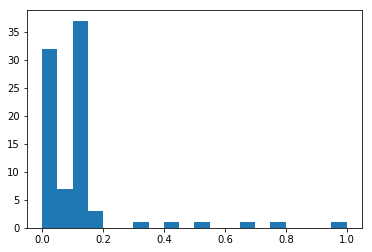

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.hist(azdias.isnull().sum()/len(azdias), bins = 20)


In [15]:
# Investigate patterns in the amount of missing data in each column.
# get features by descending number of missing cols
null_prop = (azdias.isnull().sum()/len(azdias)).sort_values(ascending=False)
print(null_prop)

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

In [16]:
#look at patterns in data
null_prop.value_counts()

0.000000    24
0.130736     7
0.149597     6
0.005446     6
0.082470     4
0.104517     4
0.105182     3
0.111479     3
0.124768     3
0.177357     2
0.087287     2
0.109260     2
0.082997     1
0.111769     1
0.440203     1
0.109147     1
0.997576     1
0.108848     1
0.106115     1
0.121536     1
0.118714     1
0.534687     1
0.166051     1
0.655967     1
0.348137     1
0.020587     1
0.109549     1
0.121366     1
0.003233     1
0.104525     1
0.769554     1
dtype: int64

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
less_otlr = null_prop.where(null_prop < .2).dropna().index
otlr = null_prop.where(null_prop > .2).dropna().index
azdias = azdias[less_otlr]

In [18]:
less_otlr

Index(['REGIOTYP', 'KKK', 'W_KEIT_KIND_HH', 'KBA05_ANTG4', 'KBA05_GBZ',
       'MOBI_REGIO', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'PLZ8_GBZ',
       'PLZ8_HHZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'PLZ8_ANTG1', 'PLZ8_ANTG3',
       'PLZ8_ANTG2', 'SHOPPER_TYP', 'VERS_TYP', 'HEALTH_TYP',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'KBA13_ANZAHL_PKW',
       'ANZ_HAUSHALTE_AKTIV', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015', 'LP_LEBENSPHASE_FEIN', 'RELAT_AB', 'ARBEIT',
       'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'LP_LEBENSPHASE_GROB', 'INNENSTADT',
       'EWDICHTE', 'BALLRAUM', 'GEBAEUDETYP_RASTER', 'MIN_GEBAEUDEJAHR',
       'GEBAEUDETYP', 'WOHNLAGE', 'OST_WEST_KZ', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'KONSUMNAEHE', 'ANZ_PERSONEN', 'SOHO_KZ',
       'ANZ_TITEL', 'WOHNDAUER_2008', 'HH_EINKOMMEN_SCORE', 'CJT_GESAMTTYP',
       'RETOURTYP_BK_S', 'ONLINE_AFFINITAET', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'GFK_URLAUBERTYP', 'ALTERSKATEGORIE_GROB',
       'F

In [19]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

After investigating the missing data in the dataset, its clear there are patterns existing with regards to missing data in columns. We have groups of 7, 6 and 6 missing 13%, 15% and 5.5% of data respectively. 

After looking at the histogram and seeing 6 apparent outliers, I decided to use more than 20% of data missing as my cut-off as to whats considered an outlier. As a result, 6 columns were removed. These were 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR' and 'ALTER_HH'.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
# How much data is missing in each row of the dataset?
missing_row_count = azdias.isnull().sum(axis=1)
missing_row_count.head(n = 50)

0     43
1      0
2      0
3      7
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11    47
12     6
13     8
14    47
15     8
16     6
17    47
18     3
19     0
20    10
21     0
22     0
23     8
24    47
25     5
26    19
27     0
28     0
29     2
30    34
31     0
32     0
33     0
34     4
35    43
36     0
37     0
38     0
39     5
40     4
41     0
42     2
43     0
44     0
45     0
46    40
47     0
48    47
49     0
dtype: int64

In [21]:
missing_row_count.value_counts()

0     623209
47     45578
2      27926
43     27369
8      24592
5      22515
3      17629
1      15738
6      13771
7      13714
4      12607
34     10816
10      5410
15      4743
35      3911
13      3255
9       3042
33      2985
16      2505
14      2243
19      1180
11      1127
12       766
17       677
37       538
45       494
18       428
38       421
41       356
20       349
32       206
44       155
21       150
40       137
23       132
22       129
36        84
39        77
24        69
26        59
25        55
27        24
42        21
29        12
30         6
28         5
31         3
49         2
48         1
dtype: int64

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
below20 = azdias[azdias.isnull().sum(axis=1) <= 20]
above20 = azdias[azdias.isnull().sum(axis=1) > 20]

In [23]:
print(len(below20))
print(len(above20))

797426
93795


In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


In [25]:
col_counts = azdias.isnull().sum()
no_miss = col_counts[col_counts==0]

In [26]:
no_miss_cols = no_miss.sample(n=10).index

In [27]:
below20_nomiss = below20[no_miss_cols]
above20_nomiss = above20[no_miss_cols]

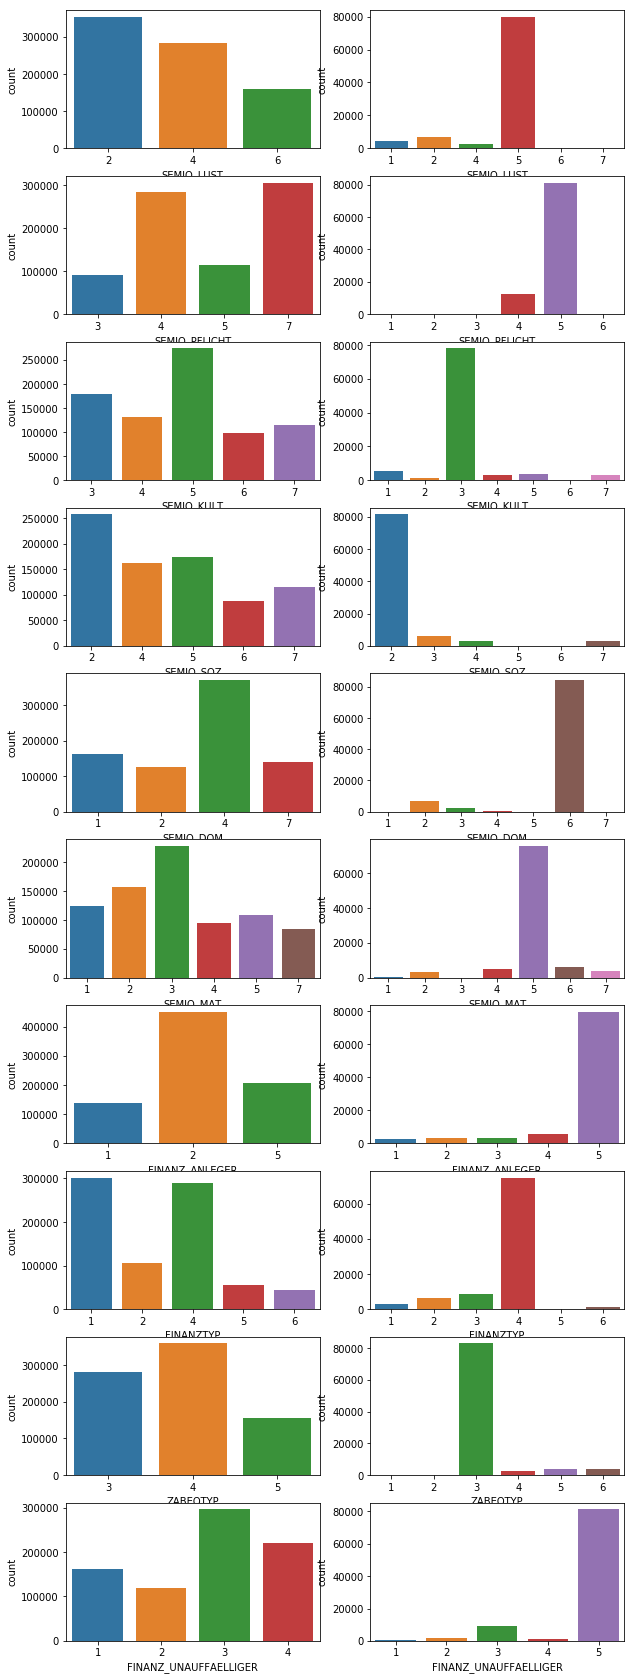

In [28]:
fig, axs = plt.subplots(10,2, figsize = (10, 30))
for i in range(10): 
    sns.countplot(ax=axs[i,0], data = below20_nomiss[no_miss_cols[i]], x=below20_nomiss[no_miss_cols[i]])
    sns.countplot(ax=axs[i,1], data = above20_nomiss[no_miss_cols[i]], x=above20_nomiss[no_miss_cols[i]])

#### Discussion 1.1.3: Assess Missing Data in Each Row

Data with lots of missing values seem to be distributed very differently, which suggests that we shouldn't decide to drop the rows with missing values until further investigating is undertaken.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
feat_info[feat_info.attribute.isin(list(azdias.columns.values))]

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


In [30]:
# How many features are there of each data type?
feat_info_red = feat_info[feat_info.attribute.isin(list(azdias.columns.values))]
feat_info_red['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_vars = feat_info_red[feat_info_red['type'] == 'categorical']['attribute']
categorical_vars

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.
var_counts = pd.Series(below20[categorical_vars].nunique())
binary = below20[var_counts.where(var_counts ==2).dropna().index]
non_binary = below20[var_counts.where(var_counts >2).dropna().index]

In [33]:
# Check if binary vars are numerical
print(binary.dtypes)
# OST_WEST_KZ of type object
OWK = binary['OST_WEST_KZ']

ANREDE_KZ             int64
GREEN_AVANTGARDE      int64
SOHO_KZ             float64
VERS_TYP            float64
OST_WEST_KZ          object
dtype: object


In [34]:
# OST_WEST_KZ not, deal with in non_binary
binary = binary.drop(columns = 'OST_WEST_KZ')

In [35]:
non_binary.insert(loc = len(non_binary.columns), column = 'OST_WEST_KZ', value = OWK)


In [36]:
below20 = pd.get_dummies(below20, columns = non_binary.columns)


#### Discussion 1.2.1: Re-Encode Categorical Features

Did not drop any multi-level categorical features as I decided to use one-hot encoding to encode them as dummy variables. Although 'OST_WEST_KZ' is a binary feature, I also had to use one-hot encoding since it wasn't numerical in type.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
below20['PRAEGENDE_JUGENDJAHRE']
def recode_dec(old_var):
    if old_var in (1,2):
        return 0
    if old_var in (3,4):
        return 1
    if old_var in (5,6,7):
        return 2
    if old_var in (8,9):
        return 3
    if old_var in (10,11,12,13):
        return 4
    if old_var in (14,15):
        return 5
    

In [38]:
def recode_mov(old_var):
    if old_var in (2,4,6,7,9,11,13,15):
        return 0.0
    else:
        return 1.0

In [39]:
below20['PRAEGENDE_JUGENDJAHRE_DEC'] = below20['PRAEGENDE_JUGENDJAHRE'].apply(recode_dec)
below20['PRAEGENDE_JUGENDJAHRE_MOV'] = below20['PRAEGENDE_JUGENDJAHRE'].apply(recode_mov)
below20 = below20.drop(columns = 'PRAEGENDE_JUGENDJAHRE')

In [40]:
below20.shape

(797426, 196)

In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def recode_wealth(old_var):
    old_var = str(old_var)
    if old_var[0] == '1':
        return 0
    if old_var[0] == '2':
        return 1
    if old_var[0] == '3':
        return 2
    if old_var[0] == '4':
        return 3
    if old_var[0] == '5':
        return 4

In [42]:
def recode_fam_type(old_var):
    old_var = str(old_var)
    if old_var[1] == '1':
        return 0
    if old_var[1] == '2':
        return 1
    if old_var[1] == '3':
        return 2
    if old_var[1] == '4':
        return 3
    if old_var[1] == '5':
        return 4

In [43]:
below20['CAMEO_INTL_2015'].apply(recode_wealth)

1         4.0
2         1.0
3         0.0
4         3.0
5         4.0
6         1.0
7         0.0
8         0.0
9         0.0
10        4.0
12        3.0
13        2.0
15        3.0
16        3.0
18        1.0
19        2.0
20        1.0
21        4.0
22        4.0
23        3.0
25        2.0
26        NaN
27        4.0
28        0.0
29        0.0
31        4.0
32        0.0
33        3.0
34        1.0
36        3.0
         ... 
891191    3.0
891192    2.0
891193    3.0
891194    1.0
891195    4.0
891196    1.0
891197    1.0
891198    0.0
891199    4.0
891200    4.0
891201    3.0
891202    3.0
891203    1.0
891204    1.0
891205    2.0
891206    1.0
891207    3.0
891208    0.0
891209    4.0
891210    3.0
891211    4.0
891212    4.0
891213    2.0
891214    1.0
891215    2.0
891216    3.0
891217    4.0
891218    1.0
891219    4.0
891220    3.0
Name: CAMEO_INTL_2015, Length: 797426, dtype: float64

In [44]:
below20['CAMEO_INTL_2015_WEALTH'] = below20['CAMEO_INTL_2015'].apply(recode_wealth)
below20['CAMEO_INTL_2015_FAM_TYPE'] = below20['CAMEO_INTL_2015'].apply(recode_fam_type)
below20 = below20.drop(columns = 'CAMEO_INTL_2015')

#### Discussion 1.2.2: Engineer Mixed-Type Features

In this step I recoded PRAEGENDE_JUGENDJAHRE into two variables PRAEGENDE_JUGENDJAHRE_DEC and PRAEGENDE_JUGENDJAHRE_MOV. Also recoded CAMEO_INTL_2015 into CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_FAM_TYPE. I left the other mixed type columns as they were.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [45]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
print(below20.shape)


(797426, 197)


In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
def clean_data(df_clean, info):
    
    def to_list_missing(missing_or_unknown):
        new_list = list()
        for values in missing_or_unknown:
            new_list.append(values[1:-1].split(","))
        return new_list

    mvs=to_list_missing(info["missing_or_unknown"])

    def rn(df2,mv,info):
        for i in range(len(mv)):
            for j in range(len(mv[i])):
                if mv[i][j] != '':
                    if not mv[i][j] in ['X','XX']:
                        mv[i][j] =int(mv[i][j])
                    df2[info['attribute'][i]] = df2[info['attribute'][i]].replace(mv[i][j],np.NaN)
        return df2

    rn(df_clean, mvs, info)
    
    null_prop = (df_clean.isnull().sum()/len(df_clean)).sort_values(ascending=False)
    less_otlr =  ['REGIOTYP', 'KKK', 'W_KEIT_KIND_HH', 'KBA05_ANTG4', 'KBA05_GBZ',
       'MOBI_REGIO', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'PLZ8_GBZ',
       'PLZ8_HHZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'PLZ8_ANTG1', 'PLZ8_ANTG3',
       'PLZ8_ANTG2', 'SHOPPER_TYP', 'VERS_TYP', 'HEALTH_TYP',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'KBA13_ANZAHL_PKW',
       'ANZ_HAUSHALTE_AKTIV', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015', 'LP_LEBENSPHASE_FEIN', 'RELAT_AB', 'ARBEIT',
       'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'LP_LEBENSPHASE_GROB', 'INNENSTADT',
       'EWDICHTE', 'BALLRAUM', 'GEBAEUDETYP_RASTER', 'MIN_GEBAEUDEJAHR',
       'GEBAEUDETYP', 'WOHNLAGE', 'OST_WEST_KZ', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'KONSUMNAEHE', 'ANZ_PERSONEN', 'SOHO_KZ',
       'ANZ_TITEL', 'WOHNDAUER_2008', 'HH_EINKOMMEN_SCORE', 'CJT_GESAMTTYP',
       'RETOURTYP_BK_S', 'ONLINE_AFFINITAET', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'GFK_URLAUBERTYP', 'ALTERSKATEGORIE_GROB',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'FINANZ_HAUSBAUER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_ANLEGER', 'FINANZ_SPARER',
       'FINANZ_MINIMALIST', 'ANREDE_KZ', 'FINANZ_VORSORGER', 'SEMIO_FAM',
       'SEMIO_SOZ', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP'] 

    df_clean = df_clean[less_otlr]
    
    dfbelow20 = df_clean[azdias.isnull().sum(axis=1) <= 20]
    dfabove20 = df_clean[azdias.isnull().sum(axis=1) > 20]
    
    info = info[info.attribute.isin(list(dfbelow20.columns.values))]
    categorical_vars = info[info['type'] == 'categorical']['attribute']
    var_counts = pd.Series(dfbelow20[categorical_vars].nunique())
    binary = dfbelow20[var_counts.where(var_counts ==2).dropna().index]
    non_binary = dfbelow20[var_counts.where(var_counts >2).dropna().index]

    OWK = binary['OST_WEST_KZ']
    binary = binary.drop(columns = 'OST_WEST_KZ')
    non_binary.insert(loc = len(non_binary.columns), column = 'OST_WEST_KZ', value = OWK)
    
    dfbelow20 = pd.get_dummies(dfbelow20, columns = non_binary.columns)
    
    def recode_dec(old_var):
        if old_var in (1,2):
            return 0
        if old_var in (3,4):
            return 1
        if old_var in (5,6,7):
            return 2
        if old_var in (8,9):
            return 3
        if old_var in (10,11,12,13):
            return 4
        if old_var in (14,15):
            return 5

    def recode_mov(old_var):
        if old_var in (2,4,6,7,9,11,13,15):
            return 0.0
        else:
            return 1.0

    dfbelow20['PRAEGENDE_JUGENDJAHRE_DEC'] = dfbelow20['PRAEGENDE_JUGENDJAHRE'].apply(recode_dec)
    dfbelow20['PRAEGENDE_JUGENDJAHRE_MOV'] = dfbelow20['PRAEGENDE_JUGENDJAHRE'].apply(recode_mov)
    dfbelow20 = dfbelow20.drop(columns = 'PRAEGENDE_JUGENDJAHRE')

    def recode_wealth(old_var):
        old_var = str(old_var)
        if old_var[0] == '1':
            return 0
        if old_var[0] == '2':
            return 1
        if old_var[0] == '3':
            return 2
        if old_var[0] == '4':
            return 3
        if old_var[0] == '5':
            return 4

    def recode_fam_type(old_var):
        old_var = str(old_var)
        if old_var[1] == '1':
            return 0
        if old_var[1] == '2':
            return 1
        if old_var[1] == '3':
            return 2
        if old_var[1] == '4':
            return 3
        if old_var[1] == '5':
            return 4

    dfbelow20['CAMEO_INTL_2015_WEALTH'] = dfbelow20['CAMEO_INTL_2015'].apply(recode_wealth)
    dfbelow20['CAMEO_INTL_2015_FAM_TYPE'] = dfbelow20['CAMEO_INTL_2015'].apply(recode_fam_type)
    dfbelow20 = dfbelow20.drop(columns = 'CAMEO_INTL_2015')

    return dfbelow20
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Get data with NaNs 

col_counts_new = below20.isnull().sum()
missing = below20[col_counts_new[col_counts_new>0].index]


In [49]:
# Problem with Imputer, set as most frequent but seems to be returning mean?
# Aware of new version of imputer but not acessible via udactiy project workspace
data_imputer = Imputer(missing_values='NaN', strategy='most_frequent')
below20[missing.columns] = data_imputer.fit_transform(below20[missing.columns])


In [50]:
# No more NaNs
below20.isnull().sum().sum()

0

In [51]:
below20.shape

(797426, 197)

In [52]:
# Apply feature scaling to the general population demographics data.
SS = StandardScaler()
scaled_below20 = pd.DataFrame(SS.fit_transform(below20), columns = below20.columns)


In [53]:
scaled_below20

,REGIOTYP,KKK,W_KEIT_KIND_HH,KBA05_ANTG4,KBA05_GBZ,MOBI_REGIO,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,PLZ8_GBZ,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAM_TYPE
0,-0.881962,-0.791302,-0.729941,2.729444,-1.658715,-1.281052,-1.009644,-0.966431,-0.595196,0.573846,...,-0.189578,-0.179852,-0.192844,-0.089743,-0.517488,0.517488,1.098531,0.530567,1.175734,-1.249157
1,-1.434704,-0.791302,-0.729941,-0.464309,-0.116232,0.091862,-0.298724,1.443945,0.407552,0.573846,...,-0.189578,-0.179852,-0.192844,-0.089743,-0.517488,0.517488,1.098531,-1.884775,-0.869674,0.766845
2,0.776262,0.269749,0.957380,-0.464309,0.655010,0.778319,1.834036,-0.162973,-0.595196,0.573846,...,-0.189578,-0.179852,-0.192844,-0.089743,-0.517488,0.517488,-0.267356,0.530567,-1.551476,-0.577156
3,0.223520,0.269749,-1.292382,-0.464309,-0.116232,0.091862,-0.298724,2.247403,0.407552,-0.337337,...,-0.189578,-0.179852,-0.192844,-0.089743,-0.517488,0.517488,-0.267356,0.530567,0.493932,0.094845
4,0.223520,1.330800,0.957380,-0.464309,0.655010,0.778319,0.412196,0.640486,-0.595196,1.485029,...,-0.189578,-0.179852,-0.192844,-0.089743,-0.517488,0.517488,-1.633243,0.530567,1.175734,0.766845
5,0.223520,0.269749,-0.729941,-0.464309,-0.116232,1.464776,1.123116,0.640486,-0.595196,1.485029,...,-0.189578,-0.179852,-0.192844,-0.089743,-0.517488,0.517488,0.415588,0.530567,-0.869674,-0.577156
6,-1.987445,-1.852353,0.394940,-0.464309,0.655010,0.778319,0.412196,0.640486,-0.595196,0.573846,...,-0.189578,-0.179852,-0.192844,-0.089743,-0.517488,0.517488,-0.267356,0.530567,-1.551476,0.766845
7,-0.881962,-1.852353,0.394940,-0.464309,1.426251,0.091862,-0.298724,-0.162973,-0.595196,-0.337337,...,-0.189578,-0.179852,-0.192844,-0.089743,-0.517488,0.517488,0.415588,-1.884775,-1.551476,0.094845
8,-1.987445,-1.852353,-0.167501,-0.464309,-0.887473,0.091862,-0.298724,1.443945,0.407552,-0.337337,...,-0.189578,-0.179852,-0.192844,-0.089743,-0.517488,0.517488,1.098531,-1.884775,-1.551476,1.438846
9,1.329003,1.330800,0.957380,-0.464309,-0.887473,-1.281052,-1.009644,2.247403,0.407552,-0.337337,...,-0.189578,-0.179852,5.185540,-0.089743,-0.517488,0.517488,-1.633243,0.530567,1.175734,-1.249157


### Discussion 2.1: Apply Feature Scaling
Before feature scaling, NaN have to be dealt with. Decided to use Imputer for this instead of removing as we would be potentially losing a lot of information in deleting all rows with NaNs. 

After dealing with NaNs, the next step was to apply feature scaling. Used StandardScaler to normailize the data which is necessary before applying PCA


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [54]:
# Apply PCA to the data.
pca = PCA()
pca.fit(scaled_below20)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [55]:
range(len(pca.singular_values_))

range(0, 197)

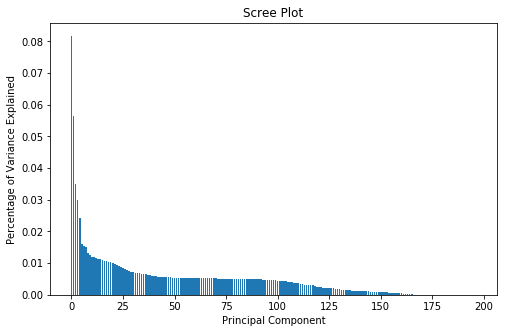

In [56]:
# Investigate the variance accounted for by each principal component.
# Use skree plot to decide how many features to retain

fig = plt.figure(figsize=(8,5))
var_expl = pca.explained_variance_ratio_
plt.bar(range(len(var_expl)), var_expl )
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.show()

Text(0,0.5,'Percentage of Variance Explained')

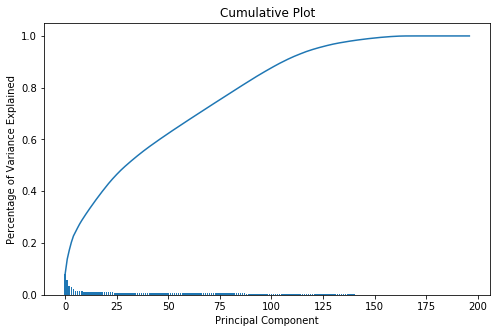

In [57]:
fig = plt.figure(figsize=(8,5))
var_expl = pca.explained_variance_ratio_
cum_vals = np.cumsum(var_expl)
ax = plt.subplot(111)
ax.bar(range(len(var_expl)), var_expl )
ax.plot(range(len(var_expl)), cum_vals)
plt.title('Cumulative Plot')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Percentage of Variance Explained')

In [58]:
cum_vals[44]

0.59050064384136325

In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_cut = PCA(n_components = 45)
pca_cut.fit(scaled_below20) 
az_pca = pca_cut.fit_transform(scaled_below20)

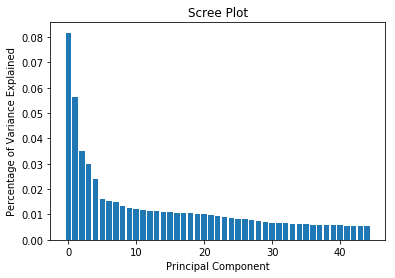

In [60]:
var_cut_expl = pca_cut.explained_variance_ratio_
plt.bar(range(len(var_cut_expl)), var_cut_expl )
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

Performed PCA on scaled data, using the scree plot and the cumulative variance plot and decided to take 45 principal components from 197. This PCs make account for almost 60% of the variability in the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [61]:
pca_cut.components_[0]

array([ 0.04718332,  0.03216545,  0.05871529,  0.12655867, -0.17591506,
       -0.18242815, -0.1750009 ,  0.01639914,  0.11380192, -0.131301  ,
        0.03477756,  0.16993533,  0.17295123, -0.17973964,  0.17824016,
        0.12184597,  0.0295896 ,  0.03004953, -0.05841072,  0.11353473,
       -0.14296367,  0.10484347,  0.11197674,  0.15257933,  0.02710273,
       -0.13066126, -0.1254507 ,  0.15045849, -0.09467377, -0.09615488,
       -0.04477632, -0.06112071, -0.13418357, -0.09499215, -0.00241414,
       -0.00469406, -0.05077034,  0.17998085, -0.00300734, -0.06286996,
       -0.07268812, -0.10109453,  0.14723105,  0.04315384,  0.04582427,
        0.10323923, -0.18163619,  0.01427354, -0.07461065,  0.04692967,
        0.02191894,  0.06990982,  0.04911926, -0.04139216, -0.04246843,
       -0.04027992,  0.03830464,  0.06057466,  0.01825994,  0.02419843,
        0.03837683,  0.07353213,  0.05010212, -0.01222368, -0.03794945,
        0.01482124,  0.01629142,  0.00635235,  0.01079256,  0.10

In [62]:
dict(zip(np.array(scaled_below20.columns),pca_cut.components_[0].T))

{'REGIOTYP': 0.047183324262806768,
 'KKK': 0.032165453075349335,
 'W_KEIT_KIND_HH': 0.058715288423213205,
 'KBA05_ANTG4': 0.12655867373111795,
 'KBA05_GBZ': -0.17591506310382865,
 'MOBI_REGIO': -0.18242815175935551,
 'KBA05_ANTG1': -0.17500090444105426,
 'KBA05_ANTG2': 0.016399143339449633,
 'KBA05_ANTG3': 0.11380191752232262,
 'PLZ8_GBZ': -0.13130099953242511,
 'PLZ8_HHZ': 0.034777559463449931,
 'PLZ8_BAUMAX': 0.16993533050953724,
 'PLZ8_ANTG4': 0.17295123016745728,
 'PLZ8_ANTG1': -0.1797396356511794,
 'PLZ8_ANTG3': 0.1782401564362816,
 'PLZ8_ANTG2': 0.12184596607814015,
 'VERS_TYP': 0.029589600003316053,
 'HEALTH_TYP': 0.030049534519824693,
 'KBA13_ANZAHL_PKW': -0.058410723137795918,
 'ANZ_HAUSHALTE_AKTIV': 0.11353473435298804,
 'LP_LEBENSPHASE_FEIN': -0.14296366729529061,
 'RELAT_AB': 0.10484347487567731,
 'ARBEIT': 0.11197674124469253,
 'ORTSGR_KLS9': 0.15257933422335895,
 'ANZ_HH_TITEL': 0.027102729755044186,
 'LP_LEBENSPHASE_GROB': -0.13066126306928985,
 'INNENSTADT': -0.12545069

In [63]:
pd.Series(pca_cut.components_[0],index=np.array(scaled_below20.columns))

REGIOTYP                     0.047183
KKK                          0.032165
W_KEIT_KIND_HH               0.058715
KBA05_ANTG4                  0.126559
KBA05_GBZ                   -0.175915
MOBI_REGIO                  -0.182428
KBA05_ANTG1                 -0.175001
KBA05_ANTG2                  0.016399
KBA05_ANTG3                  0.113802
PLZ8_GBZ                    -0.131301
PLZ8_HHZ                     0.034778
PLZ8_BAUMAX                  0.169935
PLZ8_ANTG4                   0.172951
PLZ8_ANTG1                  -0.179740
PLZ8_ANTG3                   0.178240
PLZ8_ANTG2                   0.121846
VERS_TYP                     0.029590
HEALTH_TYP                   0.030050
KBA13_ANZAHL_PKW            -0.058411
ANZ_HAUSHALTE_AKTIV          0.113535
LP_LEBENSPHASE_FEIN         -0.142964
RELAT_AB                     0.104843
ARBEIT                       0.111977
ORTSGR_KLS9                  0.152579
ANZ_HH_TITEL                 0.027103
LP_LEBENSPHASE_GROB         -0.130661
INNENSTADT  

In [64]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def component_mapping(num):
    components = pca_cut.components_[num-1]
    map = pd.Series(components,index=np.array(scaled_below20.columns)).sort_values(ascending = False)
    head = map.iloc[0:10]
    tail = map.iloc[-10:197]
    return pd.concat([head,tail])
    

component_mapping(1)

LP_STATUS_GROB_1.0        0.189396
HH_EINKOMMEN_SCORE        0.179981
CAMEO_INTL_2015_WEALTH    0.178432
PLZ8_ANTG3                0.178240
PLZ8_ANTG4                0.172951
PLZ8_BAUMAX               0.169935
ORTSGR_KLS9               0.152579
EWDICHTE                  0.150458
FINANZ_HAUSBAUER          0.147231
KBA05_ANTG4               0.126559
INNENSTADT               -0.125451
LP_LEBENSPHASE_GROB      -0.130661
PLZ8_GBZ                 -0.131301
KONSUMNAEHE              -0.134184
LP_LEBENSPHASE_FEIN      -0.142964
KBA05_ANTG1              -0.175001
KBA05_GBZ                -0.175915
PLZ8_ANTG1               -0.179740
FINANZ_MINIMALIST        -0.181636
MOBI_REGIO               -0.182428
dtype: float64

In [65]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_mapping(2)


ALTERSKATEGORIE_GROB         0.236616
FINANZ_VORSORGER             0.222097
ZABEOTYP_3                   0.199463
SEMIO_ERL                    0.180960
SEMIO_LUST                   0.165092
RETOURTYP_BK_S               0.154824
W_KEIT_KIND_HH               0.122808
CJT_GESAMTTYP_2.0            0.110764
FINANZ_MINIMALIST            0.099230
FINANZTYP_5                  0.097819
ONLINE_AFFINITAET           -0.159490
SEMIO_KULT                  -0.165923
SEMIO_RAT                   -0.172169
FINANZ_ANLEGER              -0.207049
SEMIO_TRADV                 -0.209891
SEMIO_PFLICHT               -0.209917
FINANZ_UNAUFFAELLIGER       -0.217475
SEMIO_REL                   -0.218092
FINANZ_SPARER               -0.233089
PRAEGENDE_JUGENDJAHRE_DEC   -0.234345
dtype: float64

In [66]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_mapping(3)


SEMIO_VERT                   0.313391
SEMIO_FAM                    0.254431
SEMIO_SOZ                    0.253600
SEMIO_KULT                   0.246052
FINANZTYP_5                  0.138049
FINANZ_MINIMALIST            0.129738
ZABEOTYP_1                   0.121310
SHOPPER_TYP_0.0              0.119941
SEMIO_REL                    0.110358
GREEN_AVANTGARDE             0.092865
SHOPPER_TYP_2.0             -0.091021
PRAEGENDE_JUGENDJAHRE_MOV   -0.092865
FINANZTYP_1                 -0.099631
SEMIO_RAT                   -0.149607
FINANZ_ANLEGER              -0.155522
SEMIO_ERL                   -0.205111
SEMIO_KRIT                  -0.264363
SEMIO_DOM                   -0.272816
SEMIO_KAEM                  -0.305072
ANREDE_KZ                   -0.337133
dtype: float64

### Discussion 2.3: Interpret Principal Components

The 1st principal component can be interpreted as representing wealth. Features with high absolute weights with this Principal component were related to measures of wealth, .e.g. ALTERSKATEGORIE_GROB and FINANZ_MINIMALIST.
The 2nd and third principal components weere representing personal traits such as age and personality type. The 2nd had a measure of age as it's two highest absolute weightings along with SEMIO personality traits. The 3rd PC was even more personality based and it had SEMIO personality types with very high absolute weightings

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.

scores = []
for i in range(1,30,1):
    kmeans = KMeans(n_clusters = i)
    km = kmeans.fit(az_pca)
    scores.append(np.abs(km.score(az_pca)))
    

In [121]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
index = range(10,30,1)
plt.plot(scores)
# Lost scores variable when workspace closed, takes a long time to load. Decided on 14 clusters

In [70]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Choose 14
kmeans_final = KMeans(n_clusters = 14)
# Fit the model to the data 
km_final = kmeans_final.fit(az_pca)


In [71]:
#Make clustering predictions
km_preds = km_final.predict(az_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Took the absolute value of kmeans score (as score is often negative) and chose the score that I believed the net benefit was not worth adding another cluster. This led me to chose 14. I then fit kmeans with 14 clusters to the data and generated cluster predictions on the dataset.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [72]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [73]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

clean_cust = clean_data(customers, feat_info)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [74]:
clean_cust.shape

(171388, 196)

In [75]:
cust_cols = clean_cust.columns
clean_cust = data_imputer.fit_transform(clean_cust)
clean_cust = pd.DataFrame(clean_cust, columns = cust_cols)


In [76]:
clean_cust.shape

(171388, 196)

In [77]:
clean_cust.isnull().sum().sum()

0

In [78]:
scaled_cust = pd.DataFrame(SS.fit_transform(clean_cust), columns = clean_cust.columns)

In [81]:
#pca_cust = pca_cut
pca_cust = pca_cut.fit_transform(scaled_cust)
cust_preds = km_final.predict(pca_cust)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,0,'Cluster')

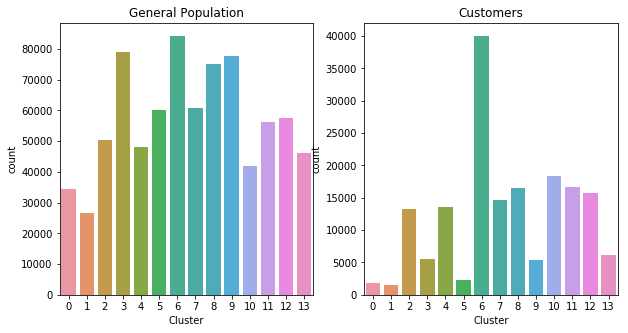

In [102]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig = plt.figure(figsize=[10,5])
plt.subplot(121)
sns.countplot(km_preds)
plt.title('General Population')
plt.xlabel('Cluster')
plt.subplot(122)
sns.countplot(cust_preds)
plt.title('Customers')
plt.xlabel('Cluster')

In [109]:
clust_6 = pd.Series(data = (pca_cut.inverse_transform(km_final.cluster_centers_[5])), index = clean_cust.columns).sort_values(ascending=False)
clust_6_head = clust_6.iloc[0:5]
clust_6_tail = clust_6.iloc[-5:197]
pd.concat([clust_6_head,clust_6_tail])

BALLRAUM          1.108847
FINANZ_ANLEGER    1.087800
MOBI_REGIO        1.054089
INNENSTADT        0.946349
FINANZTYP_4       0.893401
SEMIO_VERT       -0.951132
PLZ8_ANTG3       -1.076587
PLZ8_ANTG4       -1.097453
ORTSGR_KLS9      -1.200761
FINANZTYP_5      -1.227561
dtype: float64

In [114]:
8# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
clust_1 = pd.Series(data = (pca_cut.inverse_transform(km_final.cluster_centers_[0])), index = clean_cust.columns).sort_values(ascending=False)
clust_1_head = clust_2.iloc[0:5]
clust_1_tail = clust_2.iloc[-5:197]
pd.concat([clust_2_head,clust_2_tail])

ANZ_HAUSHALTE_AKTIV    1.478336
GEBAEUDETYP_3.0        1.405227
CAMEO_DEUG_2015_2      1.396376
CAMEO_DEU_2015_9E      1.285876
LP_FAMILIE_FEIN_1.0    1.262771
WOHNDAUER_2008        -0.996597
PLZ8_ANTG2            -1.009084
LP_STATUS_GROB_2.0    -1.132628
CAMEO_DEU_2015_3D     -1.254786
CAMEO_DEUG_2015_3     -1.586059
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

The most overrepresented segment's principal component with highest weighting was BALLRAUM, which is closest urban centre, high and low weightings for INNENSTADT and ORTSGR_KLS9 suggest the primary customer base are from a rural area. This cluster is highly weighted against an investor finance type as highlighted by FINANZ_ANLEGER and FINANZTYP_5 scores. 

Cluser 1 is an underrepresented segment, the two highest PC weightings are ANZ_HAUSHALTE_AKTIV and GEBAEUDETYP_3.0  this suggests this group is from a very urban area. CAMEO_DEUG_2015_2 and CAMEO_DEU_2015_9E indicate upper-middle class who are saving money. 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.